In [7]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
import copy
import time
import os
import torchvision.models as models

import argparse
from torch.utils.data import Subset
import csv
device = torch.device('cuda')
from ResNet import *
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

### transforms for downstream tasks

In [10]:
# transform_test = transforms.Compose([
#         # transforms.Resize(224),
#         # transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])
s=0.5
color_jitter = transforms.ColorJitter(0.4*4, 0.4*s, 0.4*s, 0.2*s)
transform_eval = transforms.Compose([
        # transforms.RandomResizedCrop((224,224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([color_jitter], p=0.5), 
        transforms.RandomGrayscale(p=0.4),
        # transforms.Resize(224),
        # transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])


In [11]:
# loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/test_data.pt")
loaded_data1 = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/data.pt")
images= loaded_data1['images']
labels = loaded_data1['labels']
images = images / 255
images = (images - images.mean(dim=(0, 2, 3), keepdim=True)) / images.std(dim=(0, 2, 3), keepdim=True)
# images1 = loaded_data['images']
# labels1 = loaded_data['labels']
# images1 = images1 / 255
# images1 = (images1 - images1.mean(dim=(0, 2, 3), keepdim=True)) / images1.std(dim=(0, 2, 3), keepdim=True)
# print(images1.shape)
# print(labels1.shape)
# print(images.shape)
# print(labels.shape)
# train_images = images[:12250]
# train_labels = labels[:12250]
# test_images = images[12250:]
# test_labels = labels[12250:]
# print(train_images.shape)
# print(train_labels.shape)
# print(test_images.shape)
# print(test_labels.shape)

torch.Size([12250, 3, 224, 224])
torch.Size([12250])
torch.Size([13250, 3, 224, 224])
torch.Size([13250])


In [14]:
train_images = images[:15500]
train_labels = labels[:15500]
test_images = images[15500:]
test_labels = labels[15500:]
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

torch.Size([15500, 3, 224, 224])
torch.Size([15500])
torch.Size([10000, 3, 224, 224])
torch.Size([10000])


In [7]:
# loaded_data_l = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/lucknow_positive_images.pt")
# loaded_data_l.shape
# # positive_labels = torch.ones(len(loaded_data_l))
# # images_l = torch.cat((train_images,loaded_data_l))
# # labels_l = torch.cat((train_labels,positive_labels))
# # print(images_l.shape)
# # print(labels_l.shape)

In [8]:
# images.dtype
# labels_l = labels_l.to(torch.uint8)
# labels_l.dtype


In [15]:
train_labels_count = (train_labels == 1).sum()
test_labels_count = (test_labels == 1).sum()

print("Number of train labels with value 1:", train_labels_count)
print("Number of test labels with value 1:", test_labels_count)
# test_images=transform_test(test_images)

Number of train labels with value 1: tensor(962)
Number of test labels with value 1: tensor(735)


### Data preporcessing for how much percentage of the data is used for finetune

In [16]:
train_images=transform_eval(train_images)


In [17]:
# print(train_images.shape)
# print(test_images.shape)
train_set=torch.utils.data.TensorDataset(train_images,train_labels)
test_set=torch.utils.data.TensorDataset(test_images,test_labels)
train_loader=torch.utils.data.DataLoader(train_set,batch_size=512,shuffle=True,num_workers=8)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=512,shuffle=False,num_workers=8)

In [18]:
len(train_set)

15500

In [96]:
base_encoder=torchvision.models.efficientnet_b0(pretrained=True)
# base_encoder
# base_encoder = torchvision.models.resnet50(pretrained=True)
base_encoder    

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [97]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
    
    
class SimCLR_model(nn.Module):
    def __init__(self, base_encoder, projection_dim, n_features):
        super(SimCLR_model, self).__init__()

        self.base_encoder = base_encoder
        self.n_features = n_features
        self.base_encoder.classifier[1]=nn.Linear(n_features, n_features)

        self.base_encoder.linear = Identity()
        self.base_encoder.dropout = Identity()
        self.base_encoder.bn1 = Identity()
        self.base_encoder.act1 = Identity()
        self.base_encoder.dropout = Identity()
        self.base_encoder.bn2 = Identity()
        self.base_encoder.act2 = Identity()
        self.projectionHead = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.BatchNorm1d(self.n_features),
            nn.ReLU(), #non-linearity
            nn.Linear(self.n_features, projection_dim, bias=False),
            nn.BatchNorm1d(projection_dim),
        )

    def forward(self, x_i, x_j):
        h_i = self.base_encoder(x_i)
        h_j = self.base_encoder(x_j)
        
        z_i = self.projectionHead(h_i)
        z_j = self.projectionHead(h_j)
        
        return h_i, h_j, z_i, z_j

In [98]:
simclr_model = SimCLR_model(base_encoder, 128, 1280)    
simclr_model

SimCLR_model(
  (base_encoder): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [99]:
projection_dim=128
n_features= base_encoder.classifier[1].in_features
net= SimCLR_model(base_encoder, projection_dim, n_features)
net= net.to(device)
# net
print(base_encoder.classifier[1].weight) #weights of the linear layer before loading the model with SimCLR

path_paramsend = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/paramsend_bs_restart_r_bk_DB_efficient.pt"
checkpoint = torch.load(path_paramsend, map_location=torch.device('cpu'))
loss= checkpoint['loss']
epoch = checkpoint['epoch']
start_epoch=0
net.load_state_dict(checkpoint['net'])
epoch

Parameter containing:
tensor([[ 1.4077e-02,  3.1314e-04, -8.7818e-03,  ..., -1.0626e-02,
          2.6984e-02, -1.3950e-03],
        [ 2.7148e-02, -1.0036e-02, -9.8955e-03,  ..., -2.4048e-02,
         -1.2590e-02,  2.3388e-02],
        [-6.6309e-03,  1.0506e-02,  4.9202e-04,  ...,  2.7192e-02,
         -1.7115e-02,  2.6791e-02],
        ...,
        [ 1.4805e-02, -6.5034e-03,  2.6500e-02,  ..., -1.3907e-02,
          2.5047e-02,  1.5159e-02],
        [ 1.4385e-02,  2.3126e-02, -1.7917e-02,  ..., -2.6141e-02,
          1.0104e-02,  6.5614e-03],
        [-1.4175e-02,  2.7665e-02,  2.3484e-05,  ..., -1.1031e-02,
          2.3233e-02, -7.6405e-03]], device='cuda:0', requires_grad=True)


300

In [100]:
net

SimCLR_model(
  (base_encoder): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [101]:
net.base_encoder.classifier[1].weight #weights of the linear layer after loading the model with SimCLR
# print(net.base_encoder.fc.weight.shape)

Parameter containing:
tensor([[-0.0010,  0.0072,  0.0007,  ..., -0.0016,  0.0007, -0.0020],
        [ 0.0004, -0.0083, -0.0070,  ...,  0.0019, -0.0052, -0.0104],
        [ 0.0051, -0.0041,  0.0010,  ..., -0.0082, -0.0017,  0.0036],
        ...,
        [ 0.0020,  0.0015,  0.0045,  ..., -0.0036,  0.0002,  0.0062],
        [ 0.0032, -0.0015,  0.0014,  ..., -0.0029,  0.0034,  0.0076],
        [ 0.0004,  0.0012, -0.0103,  ...,  0.0145,  0.0084, -0.0117]],
       device='cuda:0', requires_grad=True)

In [102]:
net_eval= net.base_encoder

# net_eval

In [103]:
net_eval= net.base_encoder
net_eval

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [105]:
classes = ('positive', 'negetive')
# net_eval= base_encoder
n_features= net_eval.classifier[1].in_features
net_eval.linear=nn.ReLU()
net_eval.bn1=nn.Linear(n_features,n_features)
net_eval.act1=nn.ReLU()
net_eval.bn2=nn.Linear(n_features,2)
net_eval.act2=nn.Softmax(dim=1)
net_eval.classifier[1].weight


Parameter containing:
tensor([[-0.0010,  0.0072,  0.0007,  ..., -0.0016,  0.0007, -0.0020],
        [ 0.0004, -0.0083, -0.0070,  ...,  0.0019, -0.0052, -0.0104],
        [ 0.0051, -0.0041,  0.0010,  ..., -0.0082, -0.0017,  0.0036],
        ...,
        [ 0.0020,  0.0015,  0.0045,  ..., -0.0036,  0.0002,  0.0062],
        [ 0.0032, -0.0015,  0.0014,  ..., -0.0029,  0.0034,  0.0076],
        [ 0.0004,  0.0012, -0.0103,  ...,  0.0145,  0.0084, -0.0117]],
       device='cuda:0', requires_grad=True)

In [112]:
# net_eval

: 

In [107]:
net_eval.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(net_eval.parameters(), lr=0.0001)


### fine-tune the downstram model  and predict on test data

In [108]:
# net_eval
start_epoch=0


In [109]:
#train net_eval
# net_eval.train()
for epoch in range(start_epoch, start_epoch+51):
    # print('Epoch: %d' % epoch)
    net_eval.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net_eval(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    if epoch%10==0:
        print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))    



Train Loss: 8.093 | Train Acc: 0.000% (0/15500)
Train Loss: 1.758 | Train Acc: 93.710% (14525/15500)
Train Loss: 0.142 | Train Acc: 97.323% (15085/15500)
Train Loss: 0.062 | Train Acc: 98.658% (15292/15500)
Train Loss: 0.035 | Train Acc: 99.271% (15387/15500)
Train Loss: 0.022 | Train Acc: 99.639% (15444/15500)


In [110]:
result_dict = {}

In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

percent = "50%"
ssl = "SimCLR"
with torch.no_grad():    
    net_eval.eval()
    correct = 0
    total = 0
    y_pred = []
    y_test = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net_eval(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_test.extend(targets.cpu().numpy())
    
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    
    print('Test Acc: %.3f%% (%d/%d)' % (100.*correct/total, correct, total))
    print(len(y_pred), len(y_test))
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # If needed, class-specific metrics
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    class_precision = precision_score(y_test, y_pred, average=None)
    class_recall = recall_score(y_test, y_pred, average=None)
    class_f1 = f1_score(y_test, y_pred, average=None)

    print("Class-specific Accuracy:", class_accuracy)
    print("Class-specific Precision:", class_precision)
    print("Class-specific Recall:", class_recall)
    print("Class-specific F1 Score:", class_f1)
    result_dict[f"{percent} {ssl}"] = {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}
    print(result_dict)

Test Acc: 86.840% (8684/10000)
10000 10000


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
# def accuracy_score(y_pred, y):
#     return (y_pred == y)
# def get_metrics(y_pred, y_label):
#     acc = accuracy_score(y_label, y_pred)
#     f1 = f1_score(y_label, y_pred)
#     precision = precision_score(y_label, y_pred)
#     recall = recall_score(y_label, y_pred)
#     print(f"Accuracy = {acc}")
#     print(f"F1 = {f1}")
#     print(f"Precision = {precision}")
#     print(f"Recall = {recall}")
#     return acc, f1, precision, recall
# percent = "100%"
# ssl = "SimCLR"
# with torch.no_grad():    
#     net_eval.eval()
#     correct = 0
#     total = 0
#     y_pred = []
#     y_test = []
#     with torch.no_grad():
#         for batch_idx, (inputs, targets) in enumerate(test_loader):
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = net_eval(inputs)
#             _, predicted = outputs.max(1)
#             total += targets.size(0)
#             correct += predicted.eq(targets).sum().item()
#             y_pred.extend(predicted.cpu().numpy())
#             y_test.extend(targets.cpu().numpy())
#     print('Test Acc: %.3f%% (%d/%d)' % (100.*correct/total, correct, total))
#     print(len(y_pred), len(y_test))
#     y_pred=torch.tensor(y_pred)
#     y_test=torch.tensor(y_test)
#     print("Accuracy: ", accuracy_score(y_pred, y_test))

#     # result_dict[f"{percent} {ssl}"] = {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}
#     # return y_pred, y_test


In [ ]:
# y_pred,ytest=prdict(net_eval, test_loader, "30%", "ssl", device,)

In [ ]:
import pandas as pd

In [ ]:
print(result_dict)

{'50% SimCLR': {'accuracy': 0.9239900249376558, 'f1': 0.4953642384105961, 'precision': 0.7991452991452992, 'recall': 0.35892514395393477}}


In [ ]:
import pickle

file_path = "dictionary1_ssl.pkl"
with open(file_path, "wb") as file:
    pickle.dump(result_dict, file)

In [ ]:
import pickle

# Load the dictionaries from the files
with open("dictionary1_ssl.pkl", "rb") as file1, open("merged_dictionary_main.pkl", "rb") as file2:
    dict1 = pickle.load(file1)
    dict2 = pickle.load(file2)

# Merge the dictionaries
merged_dict = {**dict1, **dict2}

# Save the merged dictionary to a file
with open("merged_dictionary_main.pkl", "wb") as file:
    pickle.dump(merged_dict, file)


In [ ]:
# import pickle

# Load the merged dictionary from the file
with open("merged_dictionary_main.pkl", "rb") as file:
    merged_dict = pickle.load(file)

# Print the merged dictionary
print(merged_dict)


{'50% SimCLR': {'accuracy': 0.8941645885286783, 'f1': 0.3454657618753856, 'precision': 0.4835924006908463, 'recall': 0.2687140115163148}, '1% SimCLR': {'accuracy': 0.7966084788029926, 'f1': 0.0860600627521291, 'precision': 0.08074011774600505, 'recall': 0.09213051823416507}, '10% SimCLR': {'accuracy': 0.8674314214463841, 'f1': 0.21221102548903378, 'precision': 0.2775193798449612, 'recall': 0.17178502879078694}, '30% SimCLR': {'accuracy': 0.8766084788029925, 'f1': 0.3177054605626034, 'precision': 0.3735408560311284, 'recall': 0.2763915547024952}, '100% SimCLR': {'accuracy': 0.9054364089775561, 'f1': 0.2914798206278027, 'precision': 0.6587837837837838, 'recall': 0.1871401151631478}, '100% No_SimCLR': {'accuracy': 0.8944638403990025, 'f1': 0.3111979166666667, 'precision': 0.48380566801619435, 'recall': 0.22936660268714013}, '50% No_SimCLR': {'accuracy': 0.8751122194513715, 'f1': 0.29105322763306907, 'precision': 0.35497237569060774, 'recall': 0.24664107485604606}, '30% No_SimCLR': {'accur

In [ ]:
# df=pd.read_csv("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/SSL_Experiments/patchfill_experiments/SSL_Result.csv")
# df
# # resdf = pd.DataFrame(result_dict)
resdf = pd.DataFrame(merged_dict)
resdf



,50% SimCLR,1% SimCLR,10% SimCLR,30% SimCLR,100% SimCLR,100% No_SimCLR,50% No_SimCLR,30% No_SimCLR,10% No_SimCLR,1% No_SimCLR
accuracy,0.894165,0.796608,0.867431,0.876608,0.905436,0.894464,0.875112,0.878504,0.859751,0.89606
f1,0.345466,0.086060,0.212211,0.317705,0.291480,0.311198,0.291053,0.402355,0.264644,0.00000
precision,0.483592,0.080740,0.277519,0.373541,0.658784,0.483806,0.354972,0.411647,0.290805,0.00000
recall,0.268714,0.092131,0.171785,0.276392,0.187140,0.229367,0.246641,0.393474,0.242802,0.00000


In [ ]:
#list to tensor
y_pred = torch.tensor(y_pred)
y_test = torch.tensor(y_test)
def results(y_labels,y_pred,plot_confusion = False):
    y_labels = y_labels.to(device) 
    y_pred = y_pred.to(device)
    print(f"Accuracy = {(y_labels == y_pred).float().mean()}")
    if plot_confusion:
        cm = confusion_matrix(y_labels.cpu(), y_pred.cpu())
        unique_labels = np.unique(y_labels.cpu())
        cm_display = ConfusionMatrixDisplay(cm, display_labels=unique_labels).plot(values_format='d', cmap='Blues')
        plt.show()

Accuracy = 0.92399001121521


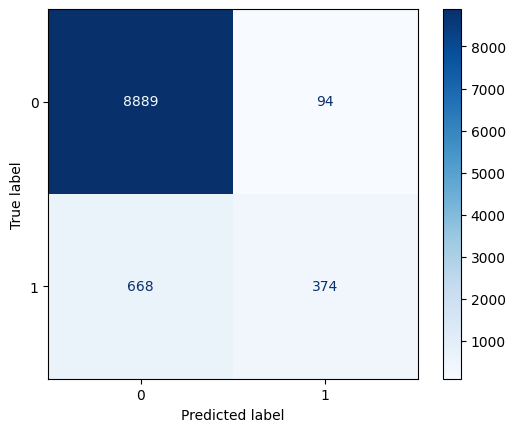

In [ ]:
results(y_test,y_pred,plot_confusion = True)

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
df = pd.read_csv("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/SSL_Experiments/patchfill_experiments/SSL_Result.csv")

# Extract the '100% SSL' column and convert it to a dictionary
ssl_dict = df.set_index('Results')['100% SSL'].to_dict()

# Display the created dictionary
ssl_dict={'100% ssl':{'accuracy': 0.913217, 'f1': 0.696559, 'precision': 0.797193, 'recall': 0.654645}}


FileNotFoundError: [Errno 2] No such file or directory: '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/SSL_Experiments/patchfill_experiments/SSL_Result.csv'

In [ ]:
file_path = "dictionary2.pkl"

# Open the file in write mode
with open(file_path, "wb") as file:
    # Write the dictionary to the file
    pickle.dump(ssl_dict, file)

In [ ]:
import pickle

# Load the dictionaries from the files
with open("merged_dictionary.pkl", "rb") as file1, open("dictionary2.pkl", "rb") as file2:
    dict1 = pickle.load(file1)
    dict2 = pickle.load(file2)

# Merge the dictionaries
merged_dict = {**dict1, **dict2}

# Save the merged dictionary to a file
with open("merged_dictionary.pkl", "wb") as file:
    pickle.dump(merged_dict, file)

In [ ]:
resdf = pd.DataFrame(merged_dict)
resdf


,30% No_ssl,10% No_ssl,1% No_ssl,1% ssl,100% No_ssl,50% No_ssl,30% ssl,10% ssl,50% ssl,100% ssl
accuracy,0.880998,0.875910,0.89606,0.836110,0.885885,0.883292,0.855262,0.863342,0.900050,0.913217
f1,0.514549,0.643723,0.47259,0.493262,0.588336,0.574813,0.687030,0.605446,0.653781,0.696559
precision,0.561424,0.655054,0.44803,0.493700,0.649453,0.631795,0.661766,0.614680,0.729032,0.797193
recall,0.517471,0.634676,0.50000,0.495393,0.570252,0.559897,0.736836,0.598394,0.622695,0.654645
